#### Import libraries and the activark script (prepareTestData)

In [2]:
import prepareTestData as activark
import numpy as np
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score

#### Create a class to store mutation information

In [3]:
class Mutation:
    def __init__(self, mutation, mutationType):
        self.mutation = mutation
        self.mutationType = [mutationType]
        self.results = {}

#### Specificy the input file (assuming the first col is in mechismo-like format)

In [4]:
INPUT_FILE = 'final_ADRN.txt'

#### Read the input file and store information in a dic using the class defined above as template. Save the extracted mutations in a new file called input.txt, which will used to give as input to activark as input in the next step.

In [5]:
dic_mutations = {}
for line in open(INPUT_FILE, 'r'):
    mutation, mutationType = line.strip().split('\t')
    if mutation not in dic_mutations:
        dic_mutations[mutation] = Mutation(mutation, mutationType)
    else:
        if mutationType not in dic_mutations[mutation].mutationType:
            dic_mutations[mutation].mutationType.append(mutationType)

l = ''
for mutation in dic_mutations:
    # if 'Activating' in dic_mutations[mutation].mutationType:
        l += mutation + '\n'
open('input.txt', 'w').write(l)
print (len(l.split('\n')[:-1]))

223


#### Run activark to make predictions
The results return a JSON object with 3 keys:
1. predictions: mutation-wise predictions
2. overEntries: number of entries(mutations) that were ignored (by defualt first 100 mutations are consdered)
3. entries_not_found: entries (mutations) that were ignored because they were not found in the database.

In [6]:
results_gbc = activark.predict(5, 'input.txt', algo='GBC')

  0%|          | 0/224 [00:00<?, ?it/s]

  2%|▏         | 4/224 [00:06<06:36,  1.80s/it]

In [6]:
import gzip
# get all the predictions from the PolyPhen2 output file
with gzip.open('../data/polyphen_output_new_test_set.tsv.gz', 'rt') as f:
    for line in f:
        if line.startswith('#'):
            continue
        else:
            line = line.strip().split('\t')
            acc = line[0].strip()
            pos = line[1].strip()
            wtAA = line[2].strip()
            mutAA = line[3].strip()
            mutation = acc + '/' + wtAA+ pos + mutAA
            prediction = line[9].strip()
            prob = line[10].strip()
            # print (mutation, acc, pos, wtAA, mutAA, prediction)
            if mutation in dic_mutations:
                if 'polyphen2' not in dic_mutations[mutation].results:
                    dic_mutations[mutation].results['polyphen2'] = prob
                # dic_mutations[mutation].results['polyphen2'] = prediction
                # dic_mutations[mutation].prob = prob
            # else:
            #     print (f'{mutation} not found in the DB')


In [7]:
import gzip
# get all the predictions from the PolyPhen2 output file
with gzip.open('../data/pmut_output.tsv.gz', 'rt') as f:
    for line in f:
        if line.startswith('#'):
            continue
        mutation = line.split()[0] + '/' + line.split()[1]
        prob = line.split()[2].split('(')[1].split(')')[0]
        # print (mutation, acc, pos, wtAA, mutAA, prediction)
        if mutation in dic_mutations:
            if 'pmut' not in dic_mutations[mutation].results:
                dic_mutations[mutation].results['pmut'] = prob
            # dic_mutations[mutation].results['polyphen2'] = prediction
            # dic_mutations[mutation].prob = prob
        # else:
        #     print (f'{mutation} not found in the DB')


In [8]:
print (dic_mutations['O96017/E501K'].results)
print (results_gbc['predictions']['Q96QP1/V1092A'])

{'polyphen2': '0.01', 'pmut': '0.1775'}
{'acc': 'Q96QP1', 'gene': 'ALPK1', 'uniprot_id': 'ALPK1_HUMAN', 'protein_name': 'Alpha-protein kinase 1', 'mutation': 'V1092A', 'adjacentSites': 'TAQHYvEFNKR', 'hmmPos': '-', 'alnPos': '-', 'region': '-', 'ptmType': '-', 'mutType': '-', 'N': 'NA\t', 'D': 'NA\t', 'A': 'NA\t', 'AILDvN': 'NA\t', 'AILDRvN': 'NA\t', 'RvN': 'NA\t', 'AIvLD': 'NA\t', 'AIvNLD': 'NA\t', 'LDvNAI': 'NA\t', 'AIvN': 'NA\t', 'LDvN': 'NA\t'}


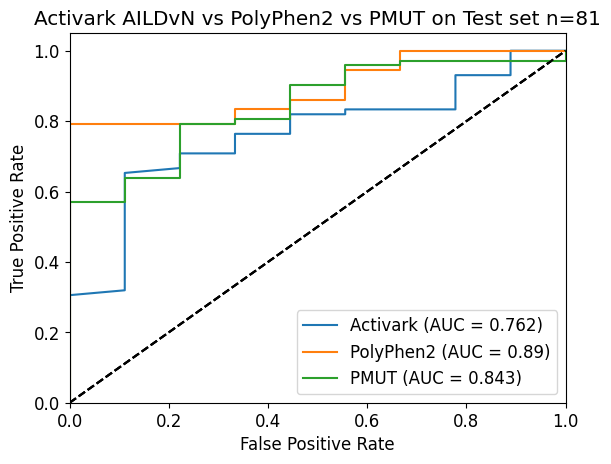

In [9]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
mpl.rcParams['font.size'] = 12

for activark_model in ['AIvLD', 'AIvNLD', 'LDvNAI', 'RvN', 'AILDvN']:
    # Clear the plot
    plt.clf()
    y_true = []
    y_pred = {'Activark': [], 'PolyPhen2': [], 'PMUT': []}
    for mutation in dic_mutations:
        mutationType = dic_mutations[mutation].mutationType
        if activark_model == 'AIvLD':
            if 'Activating' not in mutationType and 'Deactivating' not in mutationType:
                continue
        elif activark_model in ['AIvNLD', 'LDvNAI']:
            if 'Activating' not in mutationType and 'Deactivating' not in mutationType and 'Neutral' not in mutationType:
                continue
        elif activark_model == 'RvN':
            if 'Resistance' not in mutationType and 'Neutral' not in mutationType:
                continue
        elif activark_model == 'AILDvN':
            if 'Activating' not in mutationType and 'Deactivating' not in mutationType and 'Neutral' not in mutationType:
                continue
        else:
            continue
        if mutation not in results_gbc['predictions']:
            continue
        if results_gbc['predictions'][mutation][activark_model].strip() == 'NA':
            continue
        activark_prob = float(results_gbc['predictions'][mutation][activark_model])
        dic_mutations[mutation].results['activark'] = activark_prob
        if 'polyphen2' not in dic_mutations[mutation].results:
            continue
        dic_mutations[mutation].results['polyphen2'] = float(dic_mutations[mutation].results['polyphen2'])
        if 'pmut' not in dic_mutations[mutation].results:
            continue
        dic_mutations[mutation].results['pmut'] = float(dic_mutations[mutation].results['pmut'])
        y_pred['Activark'].append(dic_mutations[mutation].results['activark'])
        y_pred['PolyPhen2'].append(dic_mutations[mutation].results['polyphen2'])
        y_pred['PMUT'].append(dic_mutations[mutation].results['pmut'])
        if activark_model == 'AIvLD':
            y_true.append(1 if 'Activating' in dic_mutations[mutation].mutationType else 0)
        elif activark_model in ['AIvNLD']:
            y_true.append(1 if 'Activating' in dic_mutations[mutation].mutationType else 0)
        elif activark_model in ['LDvNAI']:
            y_true.append(1 if 'Deactivating' in dic_mutations[mutation].mutationType else 0)
        elif activark_model == 'RvN':
            y_true.append(1 if 'Resistance' in dic_mutations[mutation].mutationType else 0)
        elif activark_model == 'AILDvN':
            y_true.append(1 if 'Activating' in dic_mutations[mutation].mutationType or 'Deactivating' in dic_mutations[mutation].mutationType else 0)

    # print (len(y_true))
    # print (y_pred['Activark'])

    for model in y_pred:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred[model])
        roc_auc = auc(fpr, tpr)
        label_name = f'{model} (AUC = {round(roc_auc, 3)})'
        plt.plot(fpr, tpr, label=label_name)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(f'Activark {activark_model} vs PolyPhen2 vs PMUT on Test set n={len(y_true)}')
    plt.savefig(f'comparisons/roc_{activark_model}.svg', format='svg', dpi=600)

In [10]:
import pandas as pd
data = []
for mutation in dic_mutations:
    for mutationType in dic_mutations[mutation].mutationType:
        if mutation not in results_gbc['predictions']:
            continue
        row = []
        gene_name = results_gbc['predictions'][mutation]['gene']
        row.append(gene_name)
        acc = results_gbc['predictions'][mutation]['acc']
        row.append(acc)
        mut = results_gbc['predictions'][mutation]['mutation']
        row.append(mut)
        row.append(mutationType)
        
        activark_models = ['N', 'D', 'A', 'AIvLD', 'RvN']
        for activark_model in activark_models:
            if results_gbc['predictions'][mutation][activark_model].strip() == 'NA':
                activark_prob = 'NA'
            else:
                activark_prob = float(results_gbc['predictions'][mutation][activark_model])
            row.append(activark_prob)
        if 'polyphen2' not in dic_mutations[mutation].results:
            row.append('NA')
        else:
            row.append(float(dic_mutations[mutation].results['polyphen2']))
        if 'pmut' not in dic_mutations[mutation].results:
            row.append('NA')
        else:
            row.append(float(dic_mutations[mutation].results['pmut']))
        data.append(row)
print (data)
df = pd.DataFrame(data, columns=['Gene', 'UniProt_Acc', 'Mutation', 'MutationType',  'N', 'D', 'A', 'AIvLD', 'RvN', 'PolyPhen2', 'PMUT'])
df.to_csv('comparisons.tsv', sep='\t', index=False)

[['JAK2', 'O60674', 'H608N', 'Activating', 0.299, 0.22, 0.48, 0.665, 0.422, 0.998, 0.4058], ['JAK2', 'O60674', 'H608Y', 'Activating', 0.44, 0.207, 0.353, 0.745, 0.176, 1.0, 0.6641], ['JAK2', 'O60674', 'L604F', 'Activating', 0.493, 0.227, 0.28, 0.548, 0.767, 0.998, 0.2704], ['PAK4', 'O96013', 'I417T', 'Activating', 0.294, 0.357, 0.348, 0.551, 0.486, 0.994, 0.7833], ['EGFR', 'P00533', 'R776L', 'Activating', 0.045, 0.083, 0.872, 0.795, 0.936, 1.0, 0.8732], ['EGFR', 'P00533', 'S645C', 'Activating', 'NA', 'NA', 'NA', 'NA', 'NA', 0.999, 0.7094], ['MET', 'P08581', 'Y1234E', 'Activating', 0.009, 0.071, 0.92, 0.958, 0.941, 1.0, 'NA'], ['KIT', 'P10721', 'K509I', 'Activating', 'NA', 'NA', 'NA', 'NA', 'NA', 1.0, 0.6164], ['FGFR1', 'P11362', 'D647N', 'Activating', 0.032, 0.021, 0.947, 0.95, 0.983, 1.0, 0.5541], ['BRAF', 'P15056', 'L525R', 'Activating', 0.252, 0.338, 0.409, 0.563, 0.8, 0.76, 0.7118], ['BRAF', 'P15056', 'L597R', 'Activating', 0.03, 0.566, 0.403, 0.528, 0.824, 1.0, 0.8915], ['BRAF', '

In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, matthews_corrcoef, f1_score

y_pred_prob = []
y_pred_label = []
y_true = []
activark_models = ['AILDvN']
for activark_model in activark_models:
    for mutation in dic_mutations:
        for mutationType in dic_mutations[mutation].mutationType:
            # print (mutation, mutationType)
            if mutation not in results_gbc['predictions']:
                continue
            if results_gbc['predictions'][mutation][activark_model].strip() == 'NA':
                continue
            # if mutationType == 'Resistance':
            # if mutationType == 'Activating':
            # if mutationType == 'Deactivating':
            # if mutationType == 'Activating' or mutationType == 'Deactivating':
            if mutationType == 'Activating' or mutationType == 'Deactivating' or mutationType == 'Resistance':
                y_true.append(1)
            elif mutationType == 'Neutral':
            # elif mutationType == 'Deactivating':
                y_true.append(0)
            else:
                continue
            y_pred_prob.append(float(results_gbc['predictions'][mutation][activark_model]))
            y_pred_label.append(1 if float(results_gbc['predictions'][mutation][activark_model]) > 0.5 else 0)
print (len(y_true), len(y_pred_prob))
print ('auc', roc_auc_score(y_true, y_pred_prob))
print ('mcc', matthews_corrcoef(y_true, y_pred_label))
print ('f1', f1_score(y_true, y_pred_label))
# print count of 1 in y_true and count of 0 in y_true
print (y_true.count(1), y_true.count(0))

NameError: name 'dic_mutations' is not defined

In [12]:
import pandas as pd
from sklearn.metrics import roc_auc_score, matthews_corrcoef, f1_score

y_pred_prob = []
y_pred_label = []
y_true = []
y_mcc_true = []
y_mcc_label = []
for mutation in dic_mutations:
    for mutationType in dic_mutations[mutation].mutationType:
        if mutationType == 'Resistance':
            continue
        if mutation not in results_gbc['predictions']:
            continue
        if results_gbc['predictions'][mutation][activark_model].strip() == 'NA':
            continue
        row_true = []
        if mutationType == 'Neutral':
            row_true.append(1)
            y_mcc_true.append(0)
        else:
            row_true.append(0)
        if mutationType == 'Activating':
            row_true.append(1)
            y_mcc_true.append(1)
        else:
            row_true.append(0)
        if mutationType == 'Deactivating':
            row_true.append(1)
            y_mcc_true.append(2)
        else:
            row_true.append(0)
        activar_N = float(results_gbc['predictions'][mutation]['N'])
        activar_A = float(results_gbc['predictions'][mutation]['A'])
        activar_D = float(results_gbc['predictions'][mutation]['D'])
        row_preds = [activar_N, activar_A, activar_D]
        y_true.append(row_true)
        y_pred_prob.append(row_preds)
        if activar_N > activar_A and activar_N > activar_D:
            y_mcc_label.append(0)
        elif activar_A > activar_N and activar_A > activar_D:
            y_mcc_label.append(1)
        else:
            y_mcc_label.append(2)
        
print (y_pred)
print ('auc', roc_auc_score(y_true, y_pred_prob, multi_class='ovr'))
print ('mcc', matthews_corrcoef(y_mcc_true, y_mcc_label))
print ('f1', f1_score(y_mcc_true, y_mcc_label, average='weighted'))

{'Activark': [0.72, 0.503, 0.743, 0.838, 0.946, 0.954, 0.923, 0.999, 0.985, 0.962, 0.994, 0.988, 0.997, 0.969, 0.968, 0.951, 0.404, 0.768, 0.888, 0.86, 0.989, 0.164, 0.681, 0.89, 0.833, 0.841, 0.769, 0.879, 0.967, 0.683, 0.122, 0.972, 0.27, 0.416, 0.332, 0.047, 0.823, 0.127, 0.993, 0.954, 0.944, 0.901, 0.246, 0.963, 0.973, 0.986, 0.981, 0.981, 0.907, 0.994, 0.888, 0.897, 0.981, 0.874, 0.974, 0.21, 0.77, 0.997, 0.999, 0.97, 0.996, 0.997, 0.993, 0.106, 0.767, 0.965, 0.822, 0.979, 0.973, 0.978, 0.344, 0.887, 0.492, 0.633, 0.021, 0.972, 0.766, 0.427, 0.8, 0.838, 0.189], 'PolyPhen2': [0.998, 1.0, 0.998, 0.994, 1.0, 1.0, 0.76, 1.0, 0.98, 1.0, 0.999, 0.999, 0.998, 1.0, 1.0, 0.999, 1.0, 0.163, 0.652, 1.0, 1.0, 0.059, 0.06, 1.0, 1.0, 1.0, 1.0, 0.911, 1.0, 0.999, 1.0, 1.0, 0.97, 0.483, 1.0, 0.083, 0.999, 1.0, 0.55, 1.0, 0.988, 1.0, 1.0, 0.997, 1.0, 1.0, 0.999, 1.0, 0.999, 0.943, 1.0, 0.988, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.906, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9